In [1]:
!pip install librosa
!pip install soundfile
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 13.2 MB/s eta 0:00:00a 0:00:01


In [6]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

import logging

from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.inference.TTS import Tacotron2
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

import IPython.display as ipd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchaudio

from datasets import load_dataset # Expresso dataset
import tqdm.notebook

In [3]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='transformer.log', 
                    level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')

assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


# Utils

In [4]:
EPS = 1e-6

def equals(a, b):
    return abs(a - b) < EPS

def dtw(a, b):
    n, m = a.shape[0], b.shape[0]
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(a[i - 1] - b[j - 1])  # Euclidean distance
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j],    # Insertion
                                           dtw_matrix[i, j - 1],    # Deletion
                                           dtw_matrix[i - 1, j - 1]) # Match

    # Backtrack to find the optimal path
    i, j = n, m
    path = []

    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0:
            if equals(dtw_matrix[i, j], dtw_matrix[i - 1, j - 1] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
                j -= 1
            elif equals(dtw_matrix[i, j], dtw_matrix[i - 1, j] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
            else:
                j -= 1
        elif i > 0:
            i -= 1
        else:
            j -= 1

    path.reverse()
    return dtw_matrix[n, m], path

def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def align(signal_a, signal_b, path):
    aligned_b = np.zeros_like(signal_a)

    for idx_a, idx_b in path:
        aligned_b[idx_a] = signal_b[idx_b]

    return aligned_b

def main(audio_file_1, audio_file_2):
    
    # 0. Load audio files
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)

    # 1. Extract MFCC features
    mfcc_a = librosa.feature.mfcc(y=audio_a, sr=sr_a, n_mfcc=13).T
    mfcc_b = librosa.feature.mfcc(y=audio_b, sr=sr_b, n_mfcc=13).T

    # 2. Normalise MFCC features
    mfcc_a_normalised = (mfcc_a - np.mean(mfcc_a, axis=0))/(np.std(mfcc_a, axis=0))
    mfcc_b_normalised = (mfcc_b - np.mean(mfcc_b, axis=0))/(np.std(mfcc_b, axis=0))

    # 3. Perform DTW
    _, path = dtw(mfcc_a_normalised, mfcc_b_normalised)

    # 4. Align audio_b using DTW path
    mfcc_b_aligned = align_mfcc(mfcc_a_normalised, mfcc_b, path)
    audio_b_aligned = librosa.feature.inverse.mfcc_to_audio(np.einsum("ij->ji", mfcc_b_aligned))

    # 5. Export
    sf.write(f'./{audio_file_2}_aligned.wav', audio_b_aligned, sr_b)
    print(f"Aligned audio saved as '{audio_file_2}_aligned.wav'.")

    return

def naive_cut(audio_file_1, audio_file_2):
    audio_a, _ = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)
    sf.write('./audio_b_cut.wav', audio_b[:len(audio_a)], sr_b)
    print("Aligned audio saved as 'audio_b_cut.wav'.")

def naive_speed(audio_file_1, audio_file_2):
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, _ = load_audio(audio_file_2)
    sf.write('./audio_b_speed.wav', audio_b, int(sr_a*len(audio_b)/len(audio_a)))
    print("Aligned audio saved as 'audio_b_speed.wav'.")

In [5]:
# Load a pretrained HIFIGAN Vocoder
tacotron2 = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir_tts")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech", savedir="tmpdir_vocoder")

def view_spectrogram(spectrogram, title="Mel Spectrogram", n_mels=80):
    if not isinstance(spectrogram, np.ndarray):
        spectrogram = spectrogram.numpy()
    if spectrogram.shape[0] != 80:
        spectrogram = np.einsum("ij->ji", spectrogram)
    assert spectrogram.shape[0] == n_mels, f"spectrogram shape {spectrogram.shape} != ({n_mels}, seq_length)"
    print(spectrogram.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_spectrogram(file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def get_spectrogram_from_waveform(signal, rate):
    
    if isinstance(signal, np.ndarray):
        signal = torch.tensor(signal, dtype=torch.float32)
    
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def spectrogram_to_waveform(spectrogram, save_file_name):
    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform
    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def get_reconstructed_sample(file_name, save_file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_audio(sentence, save_file_name):
    
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    # 1. Mel spectrogram with properties in the Tacotron paper (or see get_reconstructed_sample)
    #    Shape = (batch_size, n_mels=80, Mel_length + 1); Mel_length proportional to length of sequence
    # 2. Mel_length = mel_output.shape[2] - 1
    # 3. Alignment
    #    Shape = (batch_size, Mel_length, Token_length) where Token_length is from tacotron2.text_to_seq(txt)

    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_mel(sentence):
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    return mel_output.squeeze() # remove the batch dimension

def mel_to_audio(mel_output, save_file_name=None, display=False):
    if isinstance(mel_output, np.ndarray):
        mel_output = torch.tensor(mel_output)
    if mel_output.shape[0] != 80:
        mel_output = torch.einsum("ij->ji", mel_output)
    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform
    if save_file_name is not None: torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)
    if display: return ipd.Audio(waveforms, rate=22050)
    return waveforms

def sample_audio(dataset, idx:int):
    print(dataset[idx])
    mel_to_audio(torch.einsum("ij->ji", dataset[idx]["data_mel"]), f"sample_{idx}.wav")
    mel_to_audio(torch.einsum("ij->ji", torch.tensor(dataset[idx]["original_data_mel"])), f"sample_{idx}_original.wav")

hyperparams.yaml:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

hyperparams.yaml:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


generator.ckpt:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

In [7]:
dataset = torch.load("/kaggle/input/speakers-combined/speakers_combined.pth")

/tmp/ipykernel_30/3468610396.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("/kaggle/input/speakers-combined/speakers_combined.pth")


# Visualise

In [8]:
dataset.keys()

dict_keys(['training_data', 'validation_data', 'testing_data'])

In [9]:
dataset["training_data"][0]

{'ai_mel': tensor([[-7.4671, -7.0331, -6.3560,  ..., -9.3178, -9.3065, -9.3439],
         [-6.8806, -6.4714, -5.5350,  ..., -8.8936, -8.9761, -8.9805],
         [-6.7652, -6.0454, -5.1494,  ..., -7.8740, -7.9375, -7.7856],
         ...,
         [-9.0617, -7.8005, -6.7182,  ..., -9.5971, -9.6392, -9.6360],
         [-8.7048, -7.5893, -6.6326,  ..., -9.4609, -9.4837, -9.4734],
         [-7.6010, -6.8215, -6.2451,  ..., -9.2015, -9.2592, -9.2336]]),
 'data_mel': tensor([[ -4.0866,  -3.7617,  -4.1284,  ...,  -8.1743,  -8.0239,  -8.1945],
         [ -4.1965,  -3.4188,  -3.3918,  ...,  -7.8066,  -7.6248,  -7.6444],
         [ -3.6188,  -2.8735,  -2.8024,  ...,  -7.7266,  -7.7713,  -7.5908],
         ...,
         [ -3.9447,  -5.6507,  -7.7484,  ..., -11.2923, -11.2104, -11.2685],
         [ -4.0106,  -5.1471,  -7.2421,  ..., -11.3910, -11.4083, -11.3667],
         [ -4.6923,  -5.3118,  -7.4402,  ..., -11.5129, -11.5129, -11.5129]]),
 'label': tensor([0])}

(80, 870)


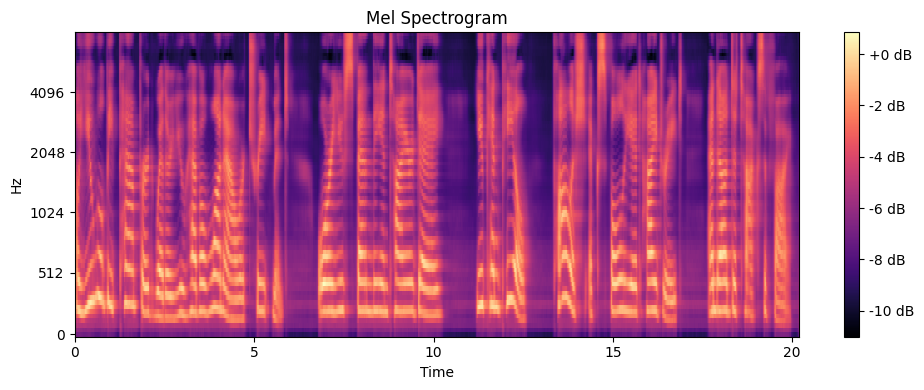

In [10]:
view_spectrogram(dataset["training_data"][0]["ai_mel"], title="Mel Spectrogram")

(80, 870)


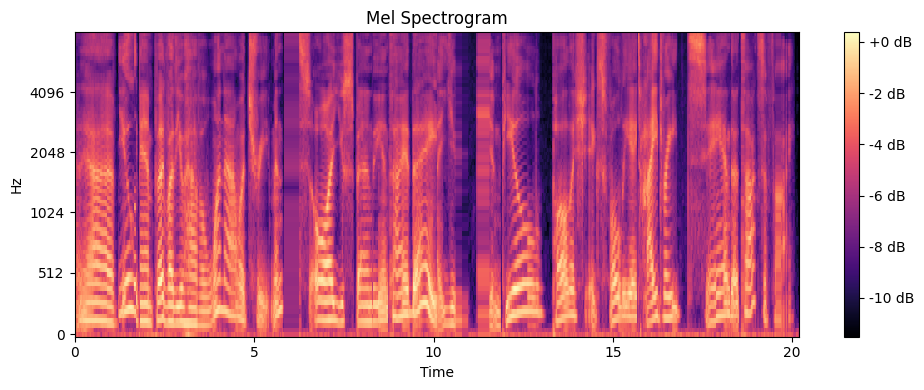

In [11]:
view_spectrogram(dataset["training_data"][0]["data_mel"], title="Mel Spectrogram")

In [12]:
mel_to_audio(dataset["training_data"][0]["ai_mel"], display=True)

In [13]:
mel_to_audio(dataset["training_data"][0]["data_mel"], display=True)

In [14]:
class ProcessedMelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, split, data):
        assert split in ("train", "valid", "test"), "invalid split"
        m = {
            "train": "training_data",
            "valid": "validation_data",
            "test": "testing_data"
        }
        self.data = data
        self.split = m[split]
        
        import random
        random.seed(225) # reproducibility
        random.shuffle(self.data["training_data"])

    def __len__(self):
        return len(self.data[self.split])

    def __getitem__(self, idx:int):
        assert idx >= 0 and idx < len(self), "Index error in ProcessedMelSpectrogramDataset"
        return self.data[self.split][idx]
    
    @staticmethod
    def collate(batch):
        
        assert torch.cuda.is_available()
        device = torch.device("cuda")
        
        ai_mel = pad_sequence(
            [item["ai_mel"] for item in batch],
            batch_first=True, padding_value=np.nan
        )
        data_mel = pad_sequence(
            [item["data_mel"] for item in batch],
            batch_first=True, padding_value=np.nan
        )

        labels = torch.cat(tuple([item["label"] for item in batch]))
        mask = torch.all(torch.where(torch.isnan(ai_mel), torch.full(ai_mel.shape, True), torch.full(ai_mel.shape, False)), 2)
        mask_check = torch.all(torch.where(torch.isnan(data_mel), torch.full(data_mel.shape, True), torch.full(data_mel.shape, False)), 2)
        assert torch.equal(mask, mask_check), "mask is dubious"
        ai_mel = pad_sequence(
            [item["ai_mel"] for item in batch],
            batch_first=True, padding_value=0.0
        )
        data_mel = pad_sequence(
            [item["data_mel"] for item in batch],
            batch_first=True, padding_value=0.0
        )
        
        batch_size = len(batch)
        _, ai_mel_max_length, _ = ai_mel.shape
        assert ai_mel.shape == (batch_size, ai_mel_max_length, 80)
        assert data_mel.shape == ai_mel.shape
        assert mask.shape == ai_mel.shape[:2]
        
        return {
            "ai_mel": ai_mel.to(device),
            "data_mel": data_mel.to(device), 
            "labels": labels.to(device),
            "mask": mask.to(device)
        }

# Model

In [15]:
class EmotionModel(nn.Module):
    def transform(self, batch):
        raise NotImplementedError()

    def compute_loss(self, batch):
        batch_size, seq_length, mels_dim = batch["ai_mel"].shape
        assert batch["data_mel"].shape == (batch_size, seq_length, mels_dim)

        predicted_mel = self.transform(batch)
        assert predicted_mel.shape == (batch_size, seq_length, mels_dim)

        target_mel = batch["data_mel"]
        assert target_mel.shape == (batch_size, seq_length, mels_dim)

        assert mels_dim == 80
        loss = torch.sum((predicted_mel - target_mel)**2)
        return loss
  
    def get_validation_metric(self, validation_dataset, batch_size=64):
        dataset = validation_dataset # replace because of caching efficiency
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, collate_fn=dataset.collate
        )
        self.eval()
        total_mse = 0.0
        total = 0
        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                loss = self.compute_loss(batch)
                total_mse += loss
                total += batch["ai_mel"].size(0)

        return total_mse/total

In [16]:
class AddPositionalEncoding(nn.Module):
    def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1, max_len=2048):
        super().__init__()
        self.max_len = max_len
        self.timing_table = nn.Parameter(torch.zeros(max_len))
        nn.init.normal_(self.timing_table)
        self.input_dropout = nn.Dropout(input_dropout)
        self.timing_dropout = nn.Dropout(timing_dropout)

    def forward(self, x, mask):
        batch_size, seq_length, d_model = x.shape
        assert x.shape == (batch_size, seq_length, d_model)
        assert mask.shape == (batch_size, seq_length)
        assert seq_length < self.max_len
        x = self.input_dropout(x)
        timing = self.timing_table[:seq_length]
        timing = self.timing_dropout(timing)
        assert timing.shape == (seq_length,), f"{timing.shape}"
        assert timing.unsqueeze(0).unsqueeze(2).shape == (1, seq_length, 1), f"{timing.unsqueeze(0).unsqueeze(2).shape}"
        assert (x + timing.unsqueeze(0).unsqueeze(2)).shape == (batch_size, seq_length, d_model), f"{(x + timing.unsqueeze(0).unsqueeze(2)).shape}"
        assert mask.unsqueeze(-1).expand(-1, -1, d_model).shape == (batch_size, seq_length, d_model), f"{mask.unsqueeze(-1).expand(-1, -1, d_model)}"
        return torch.where(mask.unsqueeze(-1).expand(-1, -1, d_model)==False, x + timing.unsqueeze(0).unsqueeze(2), x)

class TransformerEmotionModel(EmotionModel):
    def __init__(self, d_model=512, num_encoder_layers=6, dropout=0.1):
        super().__init__()
        self.n_mels = 80
        self.d_model = d_model
        self.add_timing = AddPositionalEncoding(d_model)
        self.num_encoder_layers = num_encoder_layers
        encoder_ls = []
        for _ in range(num_encoder_layers):
            encoder_ls.append(nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True, norm_first=False, dropout=dropout, dim_feedforward=d_model))
        self.encoder_layers = nn.ModuleList(encoder_ls)
        self.embedding_layer = nn.Embedding(11, d_model) # len(self.label_encoder) = 11
        self.pre_projection_layer = nn.Linear(self.n_mels, d_model)
        self.post_projection_layer = nn.Linear(d_model, self.n_mels)

    def transform(self, batch):
        
        batch_size, seq_length, _ = batch["ai_mel"].shape
        assert batch["ai_mel"].shape == (batch_size, seq_length, self.n_mels)
        
        batch_input = batch["ai_mel"]
        assert batch_input.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(batch_input))

        label = batch["labels"]
        mask = batch["mask"]
        
        assert mask.shape == (batch_size, seq_length)
        assert not torch.any(torch.isnan(mask))
        mask = torch.cat((torch.full((batch_size, 1), False).to(device), mask), 1)
        assert mask.shape == (batch_size, 1 + seq_length)
        
        assert label.shape == (batch_size,)
        label_embedded = self.embedding_layer(label).unsqueeze(1)
        assert label_embedded.shape == (batch_size, 1, self.d_model)
        assert not torch.any(torch.isnan(label_embedded))
        
        pre_adjoined = self.pre_projection_layer(batch_input)
        assert pre_adjoined.shape == (batch_size, seq_length, self.d_model)
        assert not torch.any(torch.isnan(pre_adjoined))
        
        adjoined = torch.cat((label_embedded, pre_adjoined), 1)
        assert adjoined.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined))
        
        adjoined_with_timing = self.add_timing(adjoined, mask)
        assert adjoined_with_timing.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined_with_timing))
        
        after_encoder = adjoined_with_timing
        
        for i in range(self.num_encoder_layers):
            after_encoder = self.encoder_layers[i](after_encoder, src_key_padding_mask=mask)
            assert after_encoder.shape == (batch_size, 1 + seq_length, self.d_model)
            assert not torch.any(torch.isnan(after_encoder))
        
        post_adjoined = self.post_projection_layer(after_encoder)
        assert post_adjoined.shape == (batch_size, 1 + seq_length, self.n_mels)
        assert not torch.any(torch.isnan(post_adjoined))
        
        res = post_adjoined[:,1:,:]
        assert res.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(res))
        
        return res

In [27]:
del transformer_encoder_model

In [17]:
transformer_encoder_model = TransformerEmotionModel(d_model=512, num_encoder_layers=6, dropout=0.1)
transformer_encoder_model.to(device)
#transformer_encoder_model.load_state_dict(torch.load("/kaggle/input/transformer-encoder-speaker-combined/pytorch/default/1/transformer_encoder_model_combined.pt"))

TransformerEmotionModel(
  (add_timing): AddPositionalEncoding(
    (input_dropout): Dropout(p=0.1, inplace=False)
    (timing_dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (embedding_layer): Embedding(11, 512)
  (pre_projection_layer): Linear(in_features=80, out_features=512, bias=True)
  (post_projection_layer): Linear(in_features=512, out_features

# Train

In [18]:
# Training
loss_curve = []
validation_curve = []

In [19]:
def train_processed(model, data, num_epochs, batch_size, model_file,
          learning_rate=8e-4, loss_curve=[], validation_curve=[], best_metric=None):
    training_dataset = ProcessedMelSpectrogramDataset("train", data)
    validation_dataset = ProcessedMelSpectrogramDataset("valid", data)
    
    data_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True, collate_fn=training_dataset.collate
    )
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate, 
        betas=(0.9, 0.98), 
        eps=1e-9
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(data_loader),
        pct_start=0.02,  # Warm up for 2% of the total training time
    )
    
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        logging.info(f"=== EPOCH {epoch + 1}")
        with tqdm.notebook.tqdm(
            data_loader,
            desc="epoch {}".format(epoch + 1),
            unit="batch",
            total=len(data_loader)) as batch_iterator:
            model.train()
            total_loss = 0.0
            total_num = 0
            for i, batch in enumerate(batch_iterator, start=1):
                optimizer.zero_grad()
                loss = model.compute_loss(batch)
                total_loss += loss.item()
                total_num += batch["ai_mel"].size(0)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()
                scheduler.step()
                batch_iterator.set_postfix(mean_loss=total_loss / total_num)
            validation_metric = model.get_validation_metric(validation_dataset)
            validation_curve.append(validation_metric.item())
            loss_curve.append(total_loss/total_num)
            batch_iterator.set_postfix(
                mean_loss=total_loss / total_num,
                validation_metric=validation_metric
            )
            print(f"epoch={epoch + 1}; validation={validation_metric}")
            logging.info(f"epoch={epoch + 1}; validation={validation_metric}")
            if best_metric is None or validation_metric < best_metric:
                print(
                    "Obtained a new best validation metric of {:.3f}, saving model "
                    "checkpoint to {}...".format(validation_metric, model_file)
                )
                torch.save(model.state_dict(), model_file)
                best_metric = validation_metric
        logging.info(f"=== END OF EPOCH {epoch + 1}")
    print("Reloading best model checkpoint from {}...".format(model_file))
    model.load_state_dict(torch.load(model_file))

In [20]:
train_processed(
    transformer_encoder_model, 
    dataset, 
    num_epochs=30, 
    batch_size=64,
    model_file="transformer_encoder_model_speaker_combined.pt", 
    learning_rate=5e-4, 
    loss_curve=loss_curve, 
    validation_curve=validation_curve,
    best_metric=None
)

training:   0%|          | 0/30 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=1; validation=43159.4453125
Obtained a new best validation metric of 43159.445, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 2:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=2; validation=35220.19140625
Obtained a new best validation metric of 35220.191, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 3:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=3; validation=34109.05859375
Obtained a new best validation metric of 34109.059, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 4:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=4; validation=33195.07421875
Obtained a new best validation metric of 33195.074, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 5:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=5; validation=33094.13671875
Obtained a new best validation metric of 33094.137, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 6:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=6; validation=32953.8125
Obtained a new best validation metric of 32953.812, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 7:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=7; validation=33089.55078125


epoch 8:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=8; validation=32406.748046875
Obtained a new best validation metric of 32406.748, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 9:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=9; validation=32106.462890625
Obtained a new best validation metric of 32106.463, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 10:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=10; validation=31925.3515625
Obtained a new best validation metric of 31925.352, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 11:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=11; validation=31950.771484375


epoch 12:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=12; validation=31650.8828125
Obtained a new best validation metric of 31650.883, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 13:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=13; validation=31730.412109375


epoch 14:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=14; validation=31647.33984375
Obtained a new best validation metric of 31647.340, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 15:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=15; validation=30969.158203125
Obtained a new best validation metric of 30969.158, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 16:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=16; validation=30858.83984375
Obtained a new best validation metric of 30858.840, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 17:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=17; validation=30901.0625


epoch 18:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=18; validation=30426.14453125
Obtained a new best validation metric of 30426.145, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 19:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=19; validation=30772.865234375


epoch 20:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=20; validation=30464.88671875


epoch 21:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=21; validation=30203.203125
Obtained a new best validation metric of 30203.203, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 22:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=22; validation=30168.3125
Obtained a new best validation metric of 30168.312, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 23:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=23; validation=30121.123046875
Obtained a new best validation metric of 30121.123, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 24:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=24; validation=29982.55859375
Obtained a new best validation metric of 29982.559, saving model checkpoint to transformer_encoder_model_speaker_combined.pt...


epoch 25:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=25; validation=30013.265625


epoch 26:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=26; validation=30110.779296875


epoch 27:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=27; validation=30017.109375


epoch 28:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=28; validation=29994.119140625


epoch 29:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=29; validation=30019.947265625


epoch 30:   0%|          | 0/125 [00:00<?, ?batch/s]

epoch=30; validation=30021.6328125
Reloading best model checkpoint from transformer_encoder_model_speaker_combined.pt...


/tmp/ipykernel_30/105671611.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


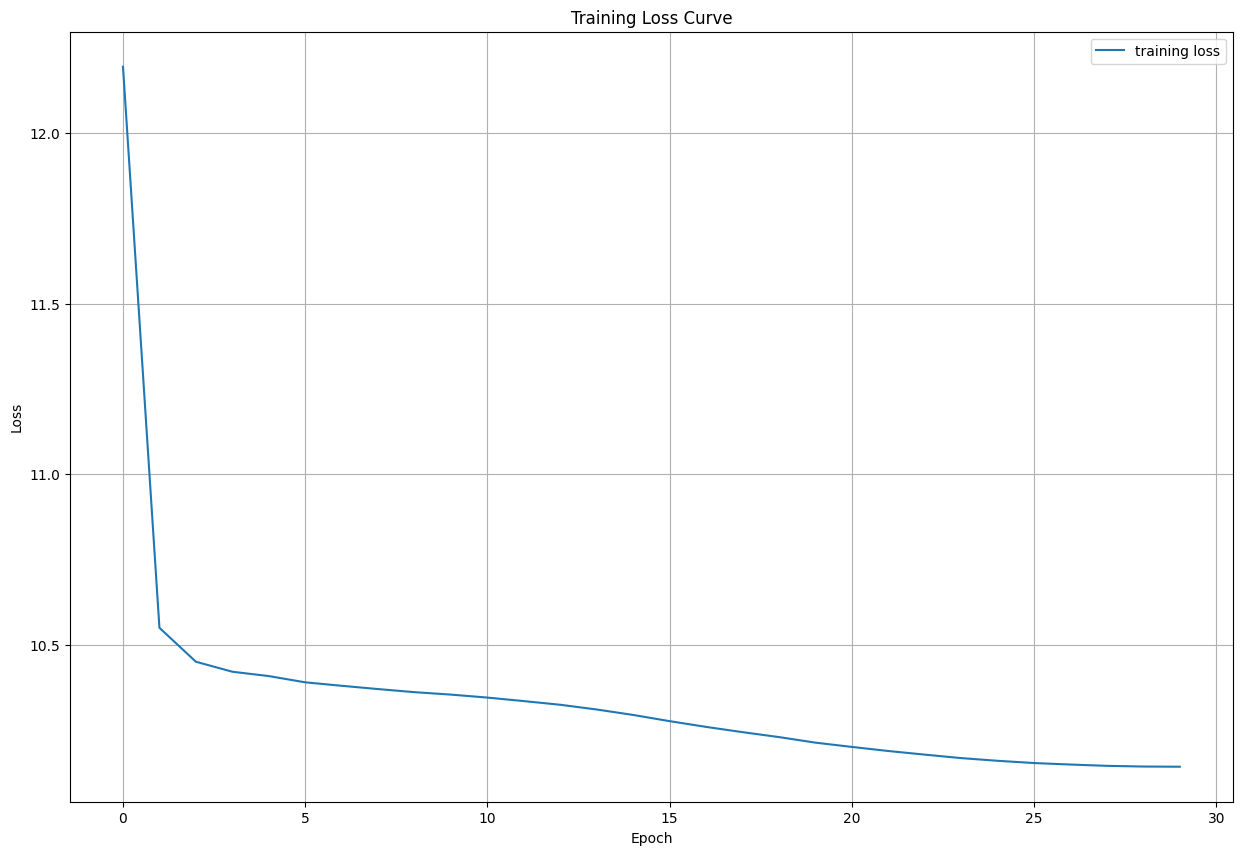

In [21]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_curve)), np.log(np.array(loss_curve)), label="training loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.grid()
plt.show()

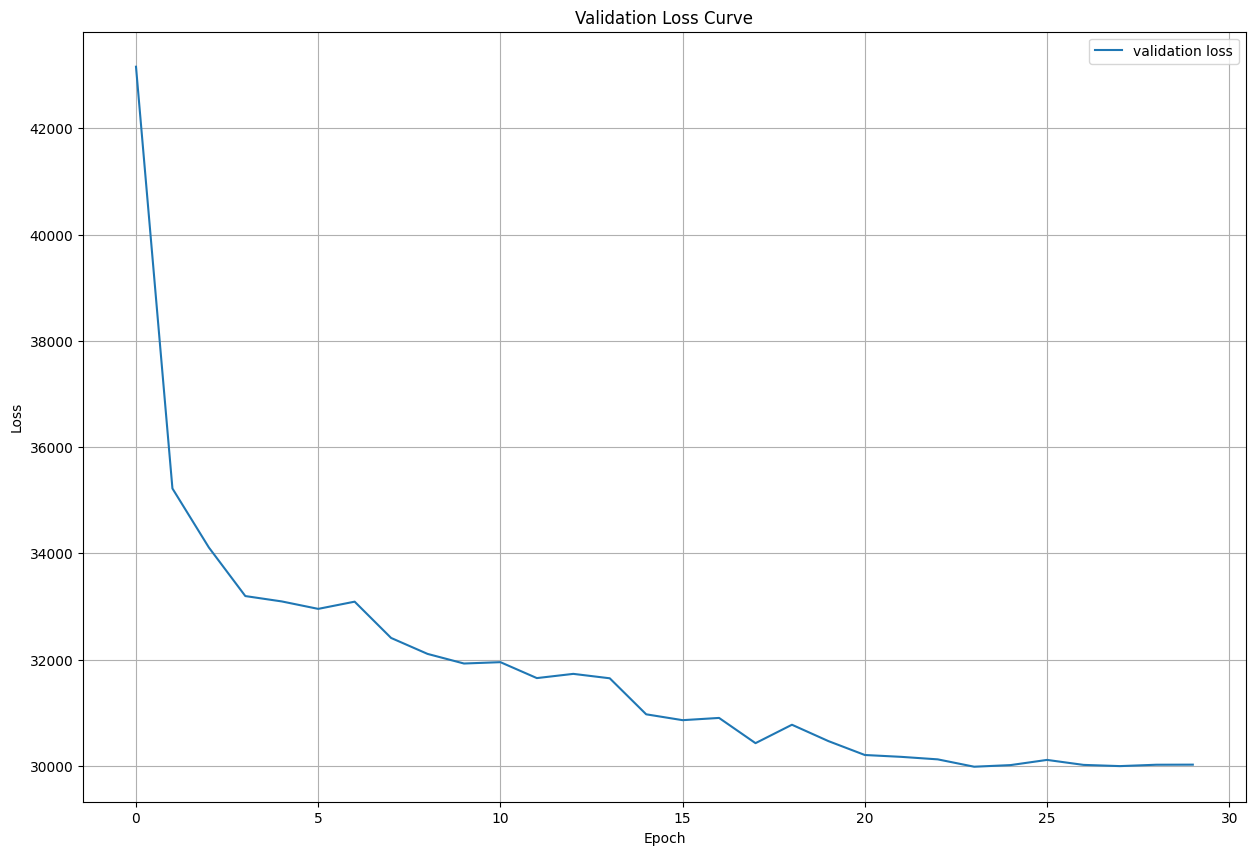

In [22]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(validation_curve)), validation_curve, label="validation loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Curve')
plt.grid()
plt.show()

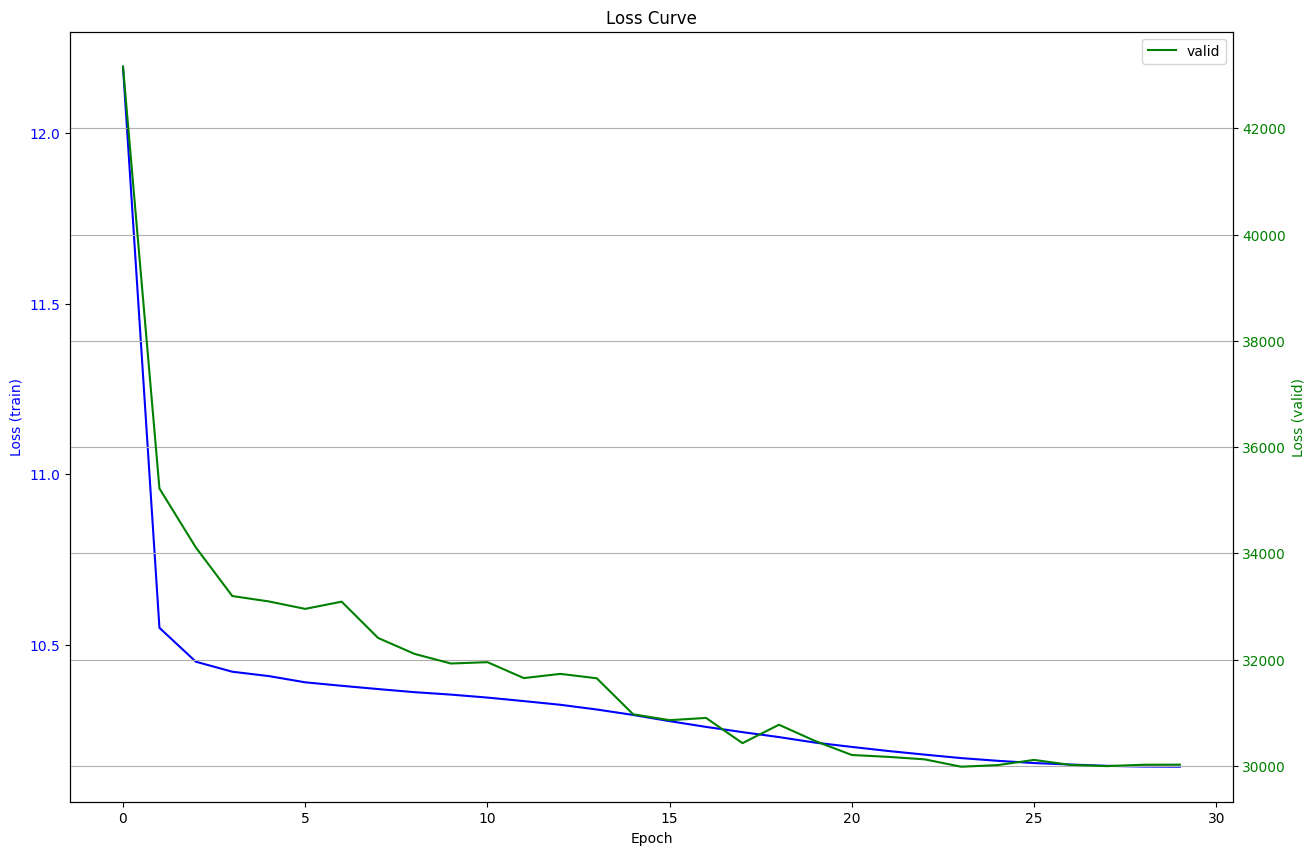

In [26]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(np.arange(len(loss_curve)), np.log(np.array(loss_curve)), 'b-', label='train')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (train)', color='b') 
ax1.tick_params(axis='y', labelcolor='b')  # Color of y-ticks

ax2 = ax1.twinx()

ax2.plot(np.arange(len(validation_curve)), validation_curve, 'g-', label='valid')
ax2.set_ylabel('Loss (valid)', color='g')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='g')  # Color of y-ticks

plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

# Predict

In [27]:
def predict_processed(model, data, num_limit=10):

    model.eval()

    test_dataset = ProcessedMelSpectrogramDataset("test", data)

    data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, collate_fn=test_dataset.collate
    )
    
    with tqdm.notebook.tqdm(
        data_loader,
        total=len(data_loader)) as batch_iterator:
        model.eval()

        for i, batch in enumerate(batch_iterator, start=1):
            if i > num_limit: break
            _, seq_length, n_mels = batch["ai_mel"].shape
            assert n_mels == 80
            pred = model.transform(batch)
            assert pred.shape == (1, seq_length, n_mels)
            assert pred.squeeze().shape == (seq_length, n_mels)
            mel_to_audio(pred.squeeze(), f"test{i}_pred.wav")
            mel_to_audio(batch["data_mel"].squeeze(), f"test{i}_actual.wav")
            mel_to_audio(batch["ai_mel"].squeeze(), f"test{i}_input.wav")

In [28]:
predict_processed(transformer_encoder_model, dataset)

  0%|          | 0/1815 [00:00<?, ?it/s]

(80, 155)


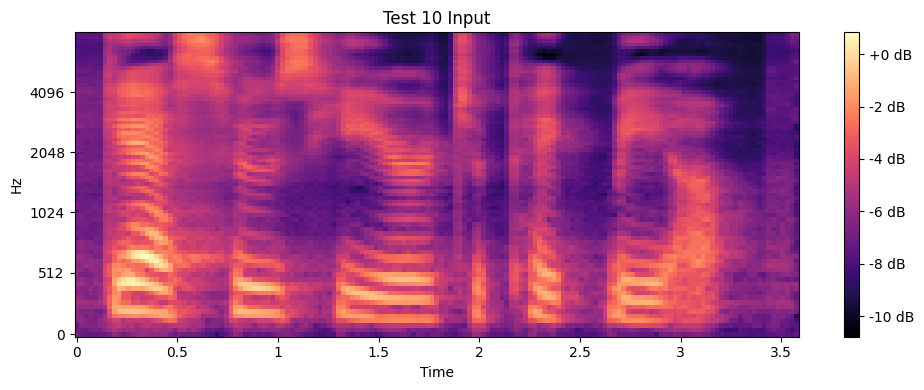

In [51]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_input.wav"), title="Test 10 Input`")

In [30]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_input.wav"), display=True)

(80, 155)


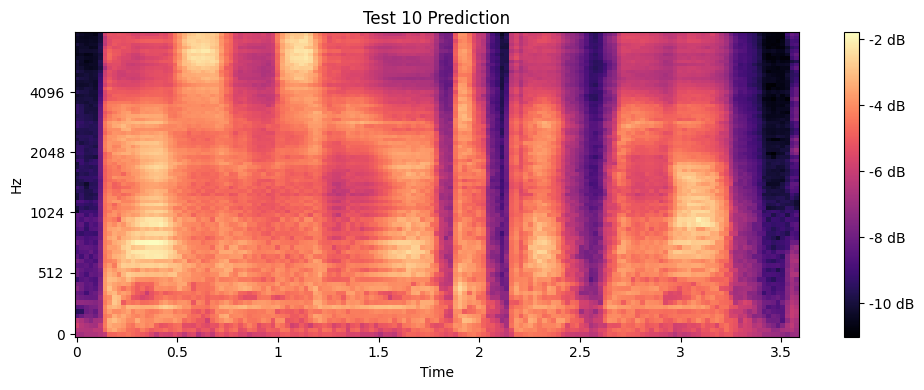

In [52]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_pred.wav"), title="Test 10 Prediction")

In [32]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_pred.wav"), display=True)

(80, 155)


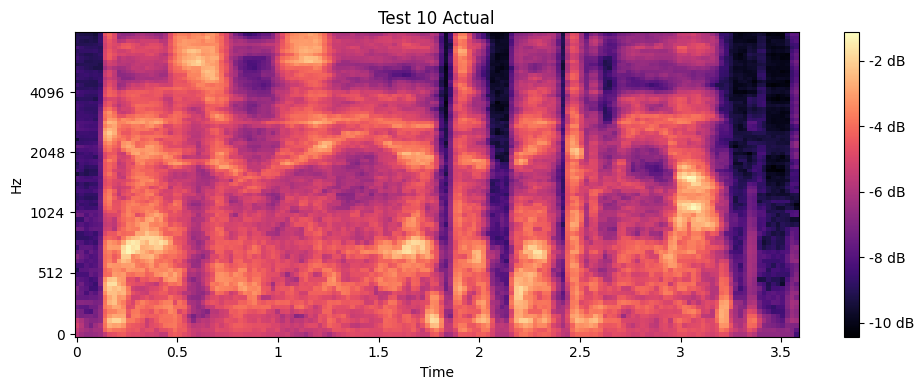

In [53]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_actual.wav"), title="Test 10 Actual")

In [34]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_actual.wav"), display=True)

(80, 269)


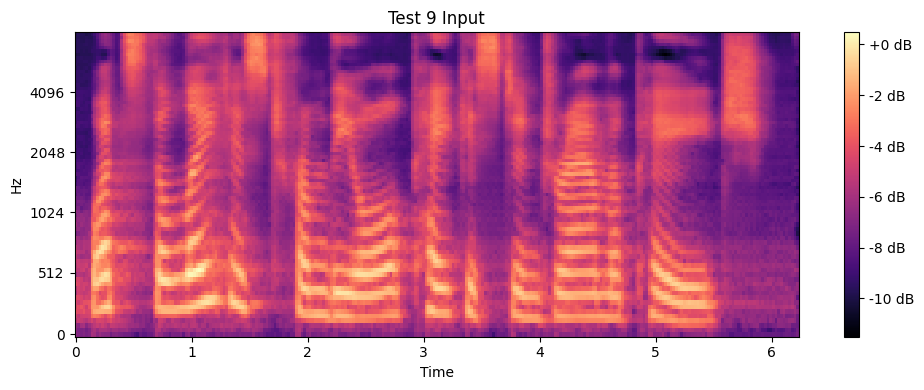

In [54]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_input.wav"), title="Test 9 Input")

(80, 269)


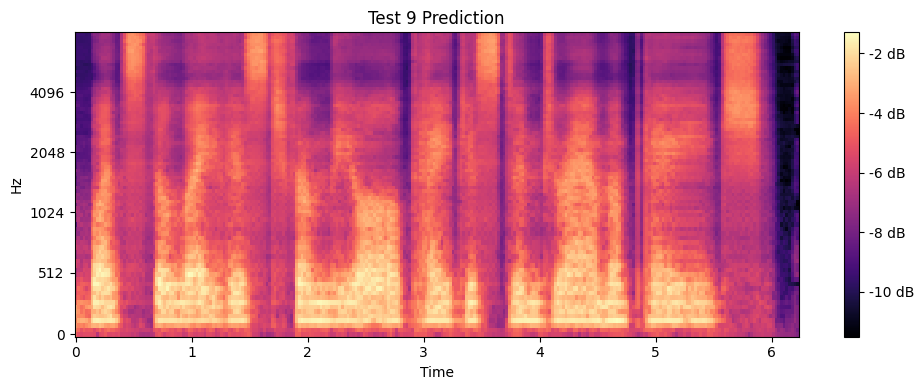

In [55]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_pred.wav"), title="Test 9 Prediction")

(80, 269)


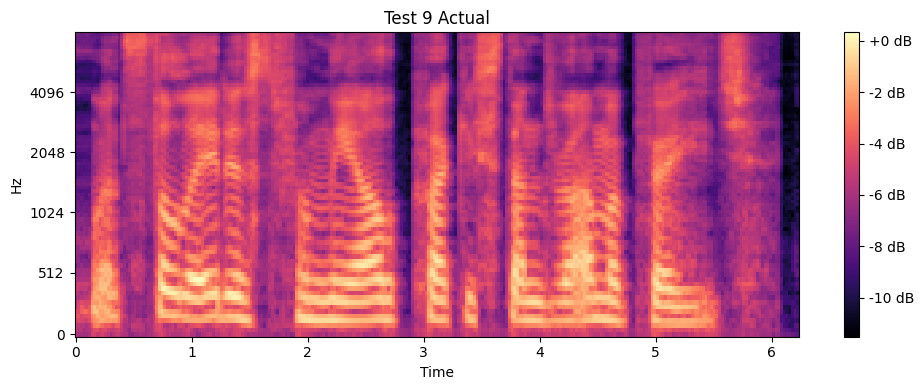

In [56]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_actual.wav"), title="Test 9 Actual")

In [41]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_input.wav"), display=True)

In [38]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_pred.wav"), display=True)

In [40]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_actual.wav"), display=True)